<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/Final_Results/ALL_PARAMS_CNN_SRGAN_FINAL_CROPPED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = "/content/drive/MyDrive/Final_Cropped/Train"
test_dir = "/content/drive/MyDrive/Final_Cropped/Test"

# List all image paths and corresponding labels
image_paths = []
labels = []

for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)

    if not os.path.isdir(class_path):
        continue

    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_dir)  # Use the directory name as the label

# Split into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)


In [5]:
unique_labels = set(labels)
unique_labels
import pandas as pd

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Create DataFrame for training data
train_df = pd.DataFrame({
    "filepath": train_paths,
    "class": train_labels
})

# Create DataFrame for validation data
val_df = pd.DataFrame({
    "filepath": val_paths,
    "class": val_labels
})



val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),  # Image size for InceptionV3
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 861 validated image filenames belonging to 3 classes.
Found 215 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 129 images belonging to 3 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(299, 299, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 299, 299, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 299, 299, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 149, 149, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 149, 149, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 74, 74, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,411 (1.87 MB)

 Trainable params: 488,451 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.3746 - loss: 1.4116 - val_accuracy: 0.3581 - val_loss: 1.0956
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 669ms/step - accuracy: 0.4035 - loss: 1.2305 - val_accuracy: 0.2558 - val_loss: 1.2192
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 673ms/step - accuracy: 0.4705 - loss: 1.0422 - val_accuracy: 0.2791 - val_loss: 1.2125
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 674ms/step - accuracy: 0.5192 - loss: 0.9438 - val_accuracy: 0.2698 - val_loss: 1.2874
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 704ms/step - accuracy: 0.5564 - loss: 0.9554 - val_accuracy: 0.2651 - val_loss: 1.4803
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 766ms/step - accuracy: 0.6146 - loss: 0.8510 - val_accuracy: 0.2651 - val_loss: 1.6509
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 757ms/step - accuracy: 0.5911 - loss: 0.9045 - val_accuracy: 0.2930 - val_loss: 1.3635
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 721ms/step - accuracy: 0.6501 - loss: 0.8133 - val_accuracy: 0.3070 

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9420 - loss: 0.2116
Test Accuracy: 0.9380


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.95      0.92        43
   Spaghetti       1.00      0.86      0.92        42
   Stringing       0.94      1.00      0.97        44

    accuracy                           0.94       129
   macro avg       0.94      0.94      0.94       129
weighted avg       0.94      0.94      0.94       129



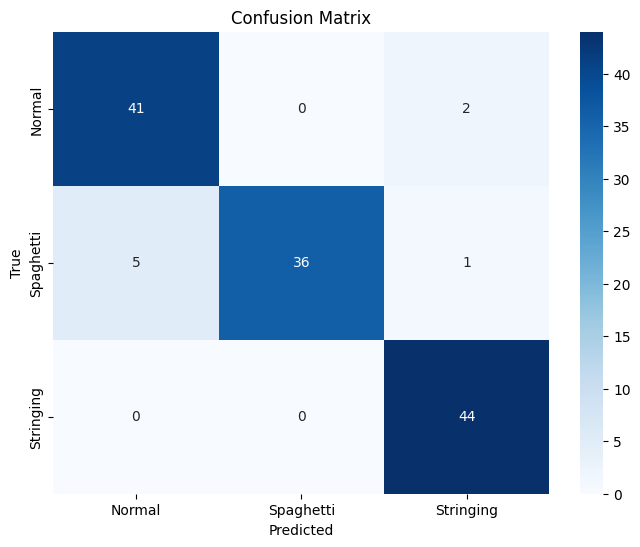

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
test_generator.reset()  # Ensure generator starts from the beginning
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot predictions to class indices
true_classes = test_generator.classes  # True labels from the generator
class_labels = list(test_generator.class_indices.keys())  # Get class labels

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.95      0.92        43
   Spaghetti       1.00      0.86      0.92        42
   Stringing       0.94      1.00      0.97        44

    accuracy                           0.94       129
   macro avg       0.94      0.94      0.94       129
weighted avg       0.94      0.94      0.94       129

Overall Accuracy: 93.80%
Overall Sensitivity (Recall): 93.80%
Overall Specificity: 96.89%
Precision (Weighted): 94.20%
F1 Score (Weighted): 93.75%
Matthews Correlation Coefficient (MCC): 0.9091
Cohen's Kappa: 0.9069
93.80%
93.80%
96.89%
94.20%
93.75%
0.9091
0.9069


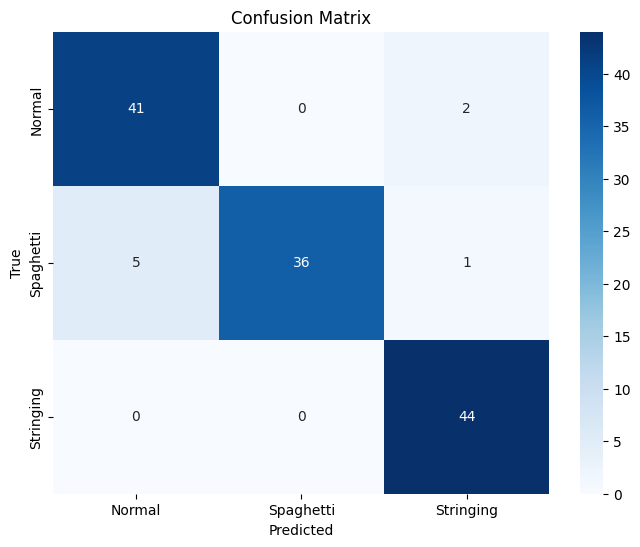

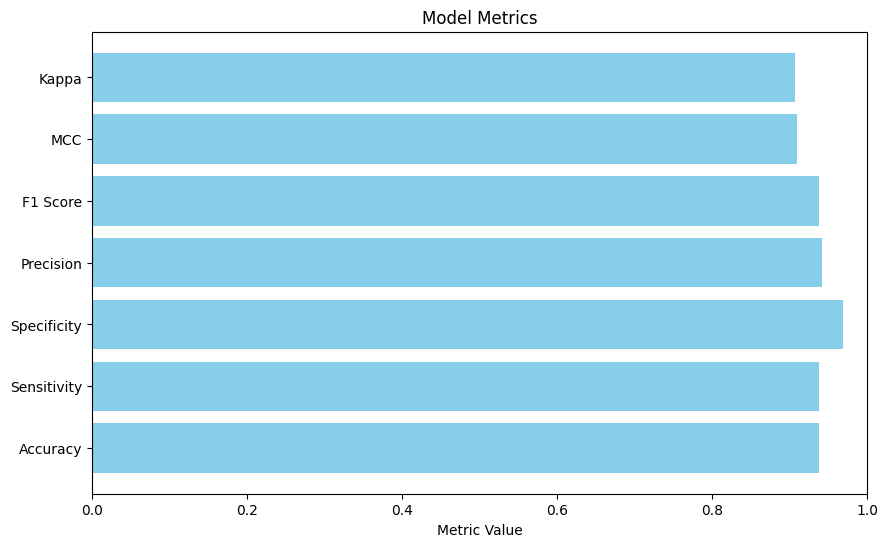

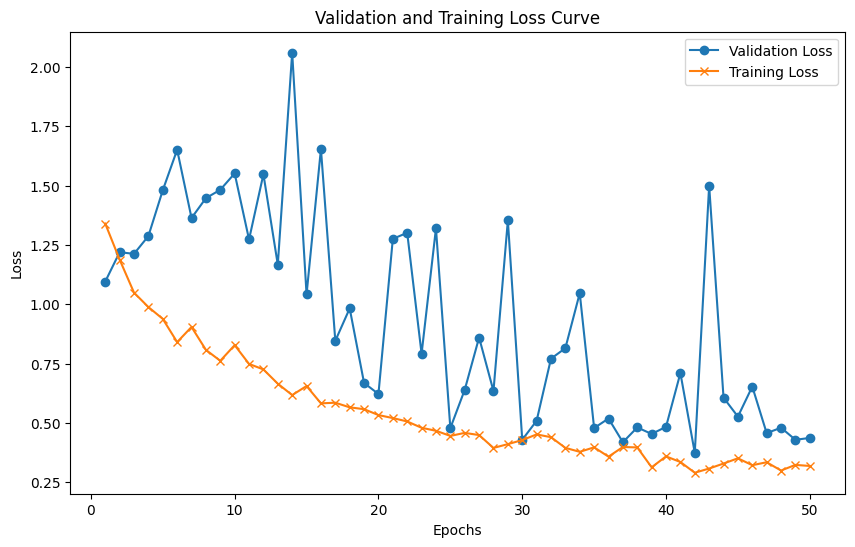

Test Loss: 0.4369216561317444
Training Loss: 0.3187812268733978


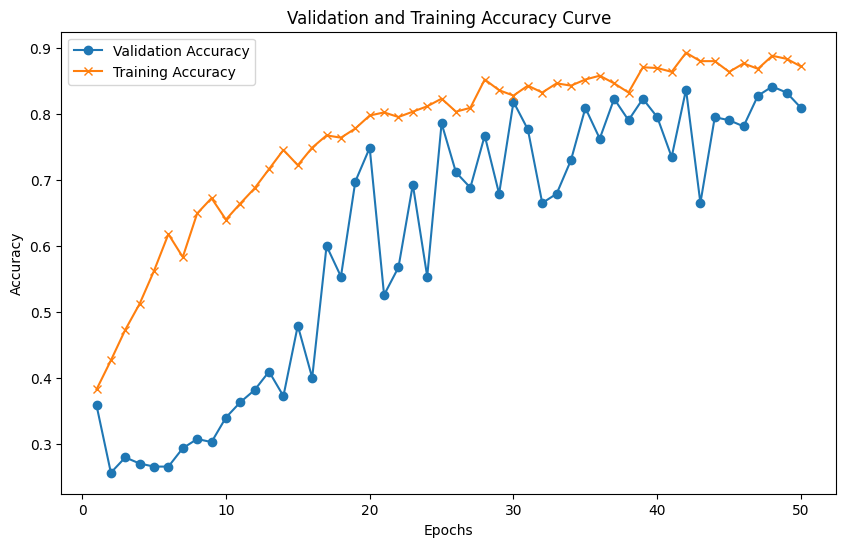

Test Accuracy: 0.8093023300170898
Training Accuracy: 0.8722415566444397


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_generator.reset()

# Get model predictions
predictions = model.predict(test_generator)  # Predict using the model
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot predictions to class indices
true_classes = test_generator.classes  # True labels from the generator
class_labels = list(test_generator.class_indices.keys())  # Get class labels

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Accuracy (from sklearn)
accuracy = accuracy_score(true_classes, predicted_classes)

# Sensitivity (Recall)
sensitivity = recall_score(true_classes, predicted_classes, average='weighted')

# Specificity (calculated per class and averaged)
specificity_per_class = []
for i in range(len(class_labels)):
    true_negative = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positive = np.sum(cm[:, i]) - cm[i, i]
    specificity = true_negative / (true_negative + false_positive)
    specificity_per_class.append(specificity)
specificity = np.mean(specificity_per_class)  # Average specificity

# Precision and F1 Score (Weighted average)
precision = precision_score(true_classes, predicted_classes, average="weighted")
f1 = f1_score(true_classes, predicted_classes, average="weighted")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(true_classes, predicted_classes)

# Cohen's Kappa
kappa = cohen_kappa_score(true_classes, predicted_classes)

# Print metrics
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Overall Specificity: {specificity * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# To Copy easily
print(f"{accuracy * 100:.2f}%")
print(f"{sensitivity * 100:.2f}%")
print(f"{specificity * 100:.2f}%")
print(f"{precision * 100:.2f}%")
print(f"{f1 * 100:.2f}%")
print(f"{mcc:.4f}")
print(f"{kappa:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot Metrics
metrics = [accuracy, sensitivity, specificity, precision, f1, mcc, kappa]
metric_names = ["Accuracy", "Sensitivity", "Specificity", "Precision", "F1 Score", "MCC", "Kappa"]

plt.figure(figsize=(10, 6))
plt.barh(metric_names, metrics, color="skyblue")
plt.xlabel("Metric Value")
plt.title("Model Metrics")
plt.xlim(0, 1)  # Metrics are between 0 and 1
plt.show()

# Assuming you have history from training for loss and accuracy curves
epochs = range(1, len(history.history['loss']) + 1)

# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss Curve')
plt.legend()
plt.show()

print("Test Loss:", history.history['val_loss'][-1])
print("Training Loss:", history.history['loss'][-1])

# Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy Curve')
plt.legend()
plt.show()

print("Test Accuracy:", history.history['val_accuracy'][-1])
print("Training Accuracy:", history.history['accuracy'][-1])
